# Basic Setup and Functions

In [1]:
!pip install snntorch --quiet

import librosa, random
import numpy as np
import pandas as pd
import os
import soundfile as sf

from pandas import DataFrame as df
import torch

from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import snntorch as snn
import torch.nn as nn

from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torchvision import transforms

from tqdm import tqdm

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 9.8 MB/s eta 0:00:00
Using cuda device


In [2]:
def Triangle_Network(num_inputs, num_outputs, beta=0.95):
    dy_dx = int(4/(num_outputs - num_inputs))
    hidden1 = num_inputs + (dy_dx * 1)
    hidden2 = num_inputs + (dy_dx * 2)
    hidden3 = num_inputs + (dy_dx * 3)

    if beta: return nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, hidden1),
                    snn.Leaky(beta=beta, init_hidden=True),
                    nn.Linear(hidden1, hidden2),
                    snn.Leaky(beta=beta, init_hidden=True),
                    nn.Linear(hidden2, hidden3),
                    snn.Leaky(beta=beta, init_hidden=True),
                    nn.Linear(hidden3, num_outputs),
                    snn.Leaky(beta=beta, init_hidden=True, output=True))

    else: return nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, hidden1),
                    nn.ReLU(),
                    nn.Linear(hidden1, hidden2),
                    nn.ReLU(),
                    nn.Linear(hidden2, hidden3),
                    nn.ReLU(),
                    nn.Linear(hidden3, num_outputs))

In [3]:
def test_network(model, dataset, loss_fn, results: df, epoch, device, printable=True):
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        all_probs = []

        for data, labels in dataloader:
            x, labels = data.to(device), labels.to(device)
            outputs = model(x)
            test_loss += loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())


            softmax = torch.nn.Softmax(dim=1)
            probabilities = softmax(outputs)
            all_probs.extend(probabilities.cpu().numpy())

    # Accuracy
    accuracy = 100 * correct / total

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predicted)

    # Recall/Sensitivity -- avoiding div by 0
    recall = recall_score(all_labels, all_predicted, average='weighted', zero_division=0)

    # Precision
    precision = precision_score(all_labels, all_predicted, average='weighted', zero_division=0)

    # F1 Score
    f1_score = (2 * precision * recall) / (precision + recall)

    # AUC-ROC
    auc_roc = 100 * roc_auc_score(all_labels, all_probs, multi_class='ovr')

    if printable: print(
        f'Epoch [{epoch + 1}] Test Loss: {test_loss / len(dataloader):.2f} '
        f'Test Accuracy: {accuracy:.2f}% F1: {f1_score}% Recall: {recall:.2f}% Precision: {precision:.2f}% '
        f'AUC-ROC: {auc_roc:.4f}%'
    )

    results = results._append({
            'Epoch': epoch + 1,
            'Accuracy': accuracy,
            'F1': f1_score,
            'Recall': recall,
            'Precision': precision,
            'Test Loss': test_loss / len(dataloader),
            'AUC-ROC': auc_roc
        }, ignore_index=True)

    return results

In [4]:
LABEL_MAPPINGS = {
    'westernart/classical': 'Classical',
    'indierock/pop': 'Rock',
    'pop/soul/electronica': 'Electronic',
    'electronica': 'Electronic',
    'jazz': 'Jazz',
    'pop/hiphop/rock': 'Pop',
    'rap/hiphop': 'Hiphop',
    'rock': 'Rock',
    'rock/folk': 'Rock',
    'westernart/baroque': 'Classical',
    'electronica/dance': 'Electronic',
    'westernart/romantic': 'Classical',
    'blues': 'Jazz',
    'pop/folk': 'Pop',
    'westernart/romantic/classical': 'Classical',
    'pop/electronica': 'Electronic',
    'latin': 'Jazz',
    'country/folk': 'Country',
    'indierock/folk/pop': 'Rock',
    'jazz/blues': 'Jazz',
    'pop/rap/rock/hiphop': 'Pop',
    'pop/experimental': 'Pop',
    'blues/rock/jazz': 'Jazz',
    'jazz/adventure': 'Jazz',
    'blues/electronica': 'Jazz',
    'jazz/pop/soul': 'Jazz',
    'funk/electronica': 'Electronic',
    'folk/pop': 'Folk',
    'indierock/rock': 'Rock',
    'jazz/electronica': 'Electronic',
    'hiphop': 'Hiphop',
    'funk/rnb/adventure': 'Soul',
    'pop': 'Pop',
    'hiphop/rap': 'Hiphop',
    'pop/gospel': 'Soul',
    'rap/metal/electronica': 'Electronic',
    'pop/rock/folk': 'Rock',
    'pop/electronica/hiphop': 'Pop',
    'metal/rap': 'Hiphop',
    'country': 'Country',
    'rap/metal': 'Hiphop',
    'country/pop': 'Country',
    'folk': 'Folk',
    'pop/rock/dance': 'Pop',
    'dance': 'Electronic',
    'pop/jazz/latin': 'Jazz',
    'pop/jazz': 'Jazz',
    'funk/rnb/electronica': 'Electronic',
    'funk/blues/jazz': 'Jazz',
    'pop/rock/soul': 'Pop',
    'pop/hiphop': 'Pop',
    'blues/funk': 'Jazz',
    'rap/metal/hiphop': 'Hiphop',
    'blues/jazz/adventure': 'Jazz',
    'folk/indierock': 'Folk',
    'adventure': 'Classical',
    'metal/rock': 'Rock',
    'blues/rock/country': 'Jazz',
    'pop/soul/rnb': 'Soul',
    'blues/rock': 'Jazz',
    'blues/rock/indierock': 'Jazz',
    'country/pop/folk': 'Country',
    'country/blues/rock': 'Country',
    'rock/funk/country': 'Rock',
    'pop/rock': 'Rock',
    'pop/blues': 'Rock',
    'blues/indierock': 'Rock',
    'blues/rock/rnb': 'Rock',
    'blues/pop/folk': 'Jazz',
    'pop/funk/adventure': 'Pop',
    'blues/rock/pop': 'Rock',
    'folk/pop/funk': 'Folk'
}


# Audio Representation

In [5]:
from google.colab import drive
drive.mount('/content/drive')
!rsync -av --exclude='spectrograms' /content/drive/MyDrive/spectrogram_tensors/ /content/spectrogram_tensors/ --quiet

Mounted at /content/drive


In [6]:
FILEPATH = '/content'
CSV = 'sample_ISD.csv'

dataset = pd.read_csv(f'/content/drive/MyDrive/{CSV}', index_col=0)
X = dataset['filename'].tolist()

In [7]:
FILEPATH = "/Users/tyler/Documents/University/YEAR3/PROJECT - COMP30040/Datasets/SmallDataset"
ORIGINAL_DIR = "audio"
SAMPLE_DIR = "audio uncompressed samples"
COMPRESSED_DIR = "audio compressed"
CSV = 'sample_ISD.csv'

dataset = pd.read_csv(f'{FILEPATH}/{CSV}', index_col=0)

X = dataset['filename'].tolist()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tyler/Documents/University/YEAR3/PROJECT - COMP30040/Datasets/SmallDataset/sample_ISD.csv'

## Sampling

In [ ]:
def sample(audio_path, duration=5.0, sr=44100):
    original_path = audio_path
    for ext in [".m4a", ".wav", ".ogg", ".flac", ".mp3"]:
        if os.path.exists(audio_path + ext):
            audio_path += ext

            total_duration = librosa.get_duration(path=audio_path)
            y, _ = librosa.load(audio_path, sr=sr, duration=total_duration)

            if total_duration < duration:
                pad_length = int((duration - total_duration) * sr)
                y = np.pad(y, (0, pad_length), mode='constant')

            start = random.uniform(0, max(0, total_duration - duration))
            y = y[int(start * sr):int((start + duration) * sr)]

            sf.write(f"{FILEPATH}/{SAMPLE_DIR}/{original_path.split('/')[-1]}.wav", y, sr)

            return y

/var/folders/mq/y1mzq23j39104lm0kgrz14180000gn/T/ipykernel_39225/2239211530.py:7: FutureWarning: PySoundFile failed. Trying audioread instead.
	Audioread support is deprecated in librosa 0.10.0 and will be removed in version 1.0.
  total_duration = librosa.get_duration(path=audio_path)
/var/folders/mq/y1mzq23j39104lm0kgrz14180000gn/T/ipykernel_39225/2239211530.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(audio_path, sr=sr, duration=total_duration)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (904,) + inhomogeneous part.

## Bitrate and Compression

In [ ]:
import os
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor

def convert_to_mp3(input_file, output_file, sample_rate=16000, bit_rate="8k", channels=1):
    !ffmpeg -i "$input_file" -ar "$sample_rate" -b:a "$bitrate" -ac "$channels" "$output_file" -hide_banner -loglevel error

def convert_directory_to_mp3(input_dir, output_dir, sample_rate=16000, bit_rate="8k"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    audio_files = [file for file in os.listdir(input_dir) if file.endswith((".m4a", ".wav", ".ogg", ".flac", ".mp3"))]

    for file in tqdm(audio_files, desc="Converting"):
            input_file_path = os.path.join(input_dir, file)
            output_file_path = os.path.join(output_dir, os.path.splitext(file)[0] + ".mp3")
            convert_to_mp3(input_file_path, output_file_path, sample_rate, bit_rate)

In [ ]:
bitdepths = np.array([2,4,8,16,24])
samplerates = np.int32(np.array([8,16,22.05,32,44.1])*1000)

with ThreadPoolExecutor() as executor:
    for bitdepth in bitdepths:
        for samplerate in samplerates:
            bitrate = (bitdepth * samplerate) / 1000
            print(f"bitdepth: {bitdepth}, samplerate: {samplerate}")
            print(f"effective bitrate: {bitrate} kbps")

            executor.submit(convert_directory_to_mp3(f"{FILEPATH}/{SAMPLE_DIR}", f"{FILEPATH}/{COMPRESSED_DIR}/{bitdepth}-{samplerate}", sample_rate=samplerate, bit_rate=f"{bitrate}k"))

bitdepth: 2, samplerate: 8000
effective bitrate: 16.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 2, samplerate: 16000
effective bitrate: 32.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 2, samplerate: 22050
effective bitrate: 44.1 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 2, samplerate: 32000
effective bitrate: 64.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 2, samplerate: 44100
effective bitrate: 88.2 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 4, samplerate: 8000
effective bitrate: 32.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 4, samplerate: 16000
effective bitrate: 64.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 4, samplerate: 22050
effective bitrate: 88.2 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 4, samplerate: 32000
effective bitrate: 128.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 4, samplerate: 44100
effective bitrate: 176.4 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 8, samplerate: 8000
effective bitrate: 64.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 8, samplerate: 16000
effective bitrate: 128.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 8, samplerate: 22050
effective bitrate: 176.4 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 8, samplerate: 32000
effective bitrate: 256.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 8, samplerate: 44100
effective bitrate: 352.8 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 16, samplerate: 8000
effective bitrate: 128.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 16, samplerate: 16000
effective bitrate: 256.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 16, samplerate: 22050
effective bitrate: 352.8 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 16, samplerate: 32000
effective bitrate: 512.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 16, samplerate: 44100
effective bitrate: 705.6 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 24, samplerate: 8000
effective bitrate: 192.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 24, samplerate: 16000
effective bitrate: 384.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 24, samplerate: 22050
effective bitrate: 529.2 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 24, samplerate: 32000
effective bitrate: 768.0 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

bitdepth: 24, samplerate: 44100
effective bitrate: 1058.4 kbps


Converting:   0%|          | 0/904 [00:00<?, ?it/s]

In [ ]:
# Assuming the directory contains all compressed files
!find . -mindepth 1 -maxdepth 1 -type d -exec sh -c 'find "$1" -type f -exec ls -l {} \; | awk "{sum += \$5} END {print \"$1\", sum}"' _ {} \

In [ ]:
from mutagen.mp3 import MP3

def get_unpacked_size(mp3_file):
    audio = MP3(mp3_file)
    duration = audio.info.length  # Duration of the audio in seconds
    bitrate = audio.info.bitrate  # Bitrate of the audio in bits per second
    # Calculate the unpacked size based on bitrate and duration
    unpacked_size = (duration * bitrate) / 8
    return unpacked_size


file_dirs = [d for d in os.listdir(f"{FILEPATH}/{COMPRESSED_DIR}") if os.path.isdir(f"{FILEPATH}/{COMPRESSED_DIR}/{d}")]
for bitrate in file_dirs:
    audio_files = [file for file in os.listdir(f"{FILEPATH}/{COMPRESSED_DIR}/{bitrate}") if file.endswith((".mp3"))]
    size = 0
    for file in audio_files:
        if os.path.exists(f"{FILEPATH}/{COMPRESSED_DIR}/{bitrate}/{file}"):
            size += get_unpacked_size(f"{FILEPATH}/{COMPRESSED_DIR}/{bitrate}/{file}")
    print(f"{bitrate.split('/')[-1]}: {size} bytes")


4-22050: 36366628.5714285 bytes
24-8000: 9177408.0 bytes
2-8000: 9177408.0 bytes
2-22050: 36366628.5714285 bytes
8-44100: 72544339.59183525 bytes
16-44100: 72544339.59183525 bytes
24-22050: 36366628.5714285 bytes
4-8000: 9177408.0 bytes
16-32000: 54478656.0 bytes
8-32000: 54478656.0 bytes
16-16000: 27336960.0 bytes
8-16000: 27336960.0 bytes
8-8000: 9177408.0 bytes
2-44100: 72544339.59183525 bytes
4-16000: 27336960.0 bytes
4-32000: 54478656.0 bytes
16-8000: 9177408.0 bytes
2-16000: 27336960.0 bytes
4-44100: 72544339.59183525 bytes
2-32000: 54478656.0 bytes
24-32000: 54478656.0 bytes
24-16000: 27336960.0 bytes
16-22050: 36366628.5714285 bytes
8-22050: 36366628.5714285 bytes
24-44100: 36272169.79591762 bytes


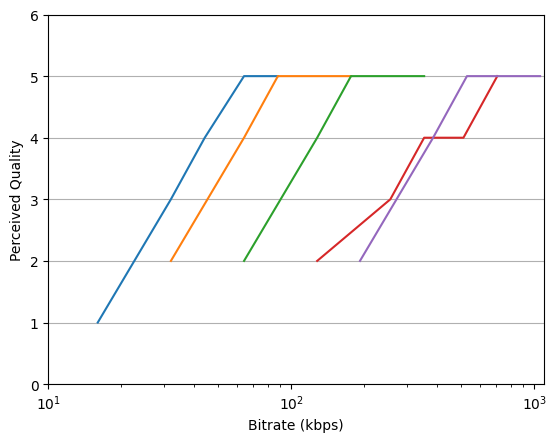

In [ ]:
from matplotlib import pyplot as plt
import tikzplotlib

bit_two = np.array([[16,32,44.1,64,88.2],[1,3,4,5,5]]).T
bit_four = np.array([[32,64,88.2,128,176.4],[2,4,5,5,5]]).T
bit_eight = np.array([[64,128,176.4,256,352.8],[2,4,5,5,5]]).T
bit_sixteen = np.array([[128,256,352.8,512,705.6],[2,3,4,4,5]]).T
bit_twentyfour = np.array([[192,384,529.2,768,1058.4],[2,4,5,5,5]]).T

plt.plot(bit_two[:,0], bit_two[:,1], label="2-bit")
plt.plot(bit_four[:,0], bit_four[:,1], label="4-bit")
plt.plot(bit_eight[:,0], bit_eight[:,1], label="8-bit")
plt.plot(bit_sixteen[:,0], bit_sixteen[:,1], label="16-bit")
plt.plot(bit_twentyfour[:,0], bit_twentyfour[:,1], label="24-bit")

plt.ylabel("Perceived Quality")
plt.xlabel("Bitrate (kbps)")
plt.xscale("log")
plt.xlim(10,1100)
plt.ylim(0, 6)
plt.grid(True, which='both', axis='y')
#plt.legend()

tikzplotlib.save("AudioRep/CompressionReception.tex")

## Spectrograms

In [ ]:
import spectrograms

AUDIO_DIR = "compressed_audio"

X = dataset[dataset['supercategory']=='music']['filename'].tolist()
Y = dataset[dataset['supercategory']=='music']['category'].map(lambda x: LABEL_MAPPINGS[x]).tolist()

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

label_mappings = {encoded_label: original_label for original_label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}
print(label_mappings)

X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2)

waveforms_train = [spectrograms.load_from_path(f"{FILEPATH}/{AUDIO_DIR}/{file}.mp3") for file in X_train]
waveforms_test = [spectrograms.load_from_path(f"{FILEPATH}/{AUDIO_DIR}/{file}.mp3") for file in X_test]

{0: 'Classical', 1: 'Country', 2: 'Electronic', 3: 'Folk', 4: 'Hiphop', 5: 'Jazz', 6: 'Pop', 7: 'Rock', 8: 'Soul'}


### Standard Spectrogram

In [ ]:
DIR = "spectrogram_tensors"


for n_fft in [512, 1024, 2048, 4096]:
    for win_length in [512, 1024, 2048, 4096]:
        if n_fft < win_length:
            continue
        else:
            os.makedirs(f"{FILEPATH}/{DIR}/spectrograms/{n_fft}-{512}-{win_length}", exist_ok=True)
            spectrogram_X_train = Tensor(np.array([x for x, _ in [spectrograms.spectrogram(sample, sr, hop=512, fft=n_fft, win=win_length) for sample, sr in waveforms_train]]))
            spectrogram_X_test = Tensor(np.array([x for x, _ in [spectrograms.spectrogram(sample, sr, hop=512, fft=n_fft, win=win_length) for sample, sr in waveforms_test]]))
            spectrogram_train = TensorDataset(spectrogram_X_train, torch.LongTensor(y_train))
            spectrogram_test = TensorDataset(spectrogram_X_test, torch.LongTensor(y_test))
            torch.save(spectrogram_train, f"{FILEPATH}/{DIR}/spectrograms/{n_fft}-{512}-{win_length}/train.pt")
            torch.save(spectrogram_test, f"{FILEPATH}/{DIR}/spectrograms/{n_fft}-{512}-{win_length}/test.pt")


for hop_length in [256, 1024, 2048]:
    os.makedirs(f"{FILEPATH}/{DIR}/spectrograms/{2048}-{hop_length}-{2048}", exist_ok=True)
    spectrogram_X_train = Tensor(np.array([x for x, _ in [spectrograms.spectrogram(sample, sr, hop=hop_length, fft=2048, win=2048) for sample, sr in waveforms_train]]))
    spectrogram_X_test = Tensor(np.array([x for x, _ in [spectrograms.spectrogram(sample, sr, hop=hop_length, fft=2048, win=2048) for sample, sr in waveforms_test]]))
    spectrogram_train = TensorDataset(spectrogram_X_train, torch.LongTensor(y_train))
    spectrogram_test = TensorDataset(spectrogram_X_test, torch.LongTensor(y_test))
    torch.save(spectrogram_train, f"{FILEPATH}/{DIR}/spectrograms/{2048}-{hop_length}-{2048}/train.pt")
    torch.save(spectrogram_test, f"{FILEPATH}/{DIR}/spectrograms/{2048}-{hop_length}-{2048}/test.pt")


### Mel Spectrogram

In [ ]:
DIR = "spectrogram_tensors"


for n_fft in [512, 1024, 2048, 4096]:
    for win_length in [512, 1024, 2048, 4096]:
        if n_fft < win_length:
            continue
        else:
            os.makedirs(f"{FILEPATH}/{DIR}/mel_spectrograms/{n_fft}-{512}-{win_length}-{128}", exist_ok=True)
            spectrogram_X_train = Tensor(np.array([x for x, _ in [spectrograms.mel_spectrogram(sample, sr, fft=n_fft, win=win_length) for sample, sr in waveforms_train]]))
            spectrogram_X_test = Tensor(np.array([x for x, _ in [spectrograms.mel_spectrogram(sample, sr, fft=n_fft, win=win_length) for sample, sr in waveforms_test]]))
            spectrogram_train = TensorDataset(spectrogram_X_train, torch.LongTensor(y_train))
            spectrogram_test = TensorDataset(spectrogram_X_test, torch.LongTensor(y_test))
            torch.save(spectrogram_train, f"{FILEPATH}/{DIR}/mel_spectrograms/{n_fft}-{512}-{win_length}-{128}/train.pt")
            torch.save(spectrogram_test, f"{FILEPATH}/{DIR}/mel_spectrograms/{n_fft}-{512}-{win_length}-{128}/test.pt")


for hop_length in [256, 1024, 2048]:
    os.makedirs(f"{FILEPATH}/{DIR}/mel_spectrograms/{2048}-{hop_length}-{2048}-{128}", exist_ok=True)
    spectrogram_X_train = Tensor(np.array([x for x, _ in [spectrograms.mel_spectrogram(sample, sr, hop=hop_length, fft=2048, win=2048) for sample, sr in waveforms_train]]))
    spectrogram_X_test = Tensor(np.array([x for x, _ in [spectrograms.mel_spectrogram(sample, sr, hop=hop_length, fft=2048, win=2048) for sample, sr in waveforms_test]]))
    spectrogram_train = TensorDataset(spectrogram_X_train, torch.LongTensor(y_train))
    spectrogram_test = TensorDataset(spectrogram_X_test, torch.LongTensor(y_test))
    torch.save(spectrogram_train, f"{FILEPATH}/{DIR}/mel_spectrograms/{2048}-{hop_length}-{2048}-{128}/train.pt")
    torch.save(spectrogram_test, f"{FILEPATH}/{DIR}/mel_spectrograms/{2048}-{hop_length}-{2048}-{128}/test.pt")


for mel_features in [64, 128, 192, 256]:
    os.makedirs(f"{FILEPATH}/{DIR}/mel_spectrograms/{2048}-{512}-{2048}-{mel_features}", exist_ok=True)
    spectrogram_X_train = Tensor(np.array([x for x, _ in [spectrograms.mel_spectrogram(sample, sr, mel=mel_features) for sample, sr in waveforms_train]]))
    spectrogram_X_test = Tensor(np.array([x for x, _ in [spectrograms.mel_spectrogram(sample, sr, mel=mel_features) for sample, sr in waveforms_test]]))
    spectrogram_train = TensorDataset(spectrogram_X_train, torch.LongTensor(y_train))
    spectrogram_test = TensorDataset(spectrogram_X_test, torch.LongTensor(y_test))
    torch.save(spectrogram_train, f"{FILEPATH}/{DIR}/mel_spectrograms/{2048}-{512}-{2048}-{mel_features}/train.pt")
    torch.save(spectrogram_test, f"{FILEPATH}/{DIR}/mel_spectrograms/{2048}-{512}-{2048}-{mel_features}/test.pt")

### MFCCs

In [ ]:
DIR = "spectrogram_tensors"

for n_fft in [512, 1024, 2048, 4096]:
    for win_length in [512, 1024, 2048, 4096]:
        if n_fft < win_length:
            continue
        else:
            os.makedirs(f"{FILEPATH}/{DIR}/mfcc_spectrograms/{n_fft}-{512}-{win_length}-{128}-{13}", exist_ok=True)
            spectrogram_X_train = Tensor(np.array([x for x, _ in [spectrograms.mfcc_spectrogram(sample, sr, fft=n_fft, win=win_length) for sample, sr in waveforms_train]]))
            spectrogram_X_test = Tensor(np.array([x for x, _ in [spectrograms.mfcc_spectrogram(sample, sr, fft=n_fft, win=win_length) for sample, sr in waveforms_test]]))
            spectrogram_train = TensorDataset(spectrogram_X_train, torch.LongTensor(y_train))
            spectrogram_test = TensorDataset(spectrogram_X_test, torch.LongTensor(y_test))
            torch.save(spectrogram_train, f"{FILEPATH}/{DIR}/mfcc_spectrograms/{n_fft}-{512}-{win_length}-{128}-{13}/train.pt")
            torch.save(spectrogram_test, f"{FILEPATH}/{DIR}/mfcc_spectrograms/{n_fft}-{512}-{win_length}-{128}-{13}/test.pt")


for hop_length in [256, 1024, 2048]:
    os.makedirs(f"{FILEPATH}/{DIR}/mfcc_spectrograms/{2048}-{hop_length}-{2048}-{128}-{13}", exist_ok=True)
    spectrogram_X_train = Tensor(np.array([x for x, _ in [spectrograms.mfcc_spectrogram(sample, sr, hop=hop_length, fft=2048, win=2048) for sample, sr in waveforms_train]]))
    spectrogram_X_test = Tensor(np.array([x for x, _ in [spectrograms.mfcc_spectrogram(sample, sr, hop=hop_length, fft=2048, win=2048) for sample, sr in waveforms_test]]))
    spectrogram_train = TensorDataset(spectrogram_X_train, torch.LongTensor(y_train))
    spectrogram_test = TensorDataset(spectrogram_X_test, torch.LongTensor(y_test))
    torch.save(spectrogram_train, f"{FILEPATH}/{DIR}/mfcc_spectrograms/{2048}-{hop_length}-{2048}-{128}-{13}/train.pt")
    torch.save(spectrogram_test, f"{FILEPATH}/{DIR}/mfcc_spectrograms/{2048}-{hop_length}-{2048}-{128}-{13}/test.pt")


for mel_features in [64, 128, 192, 256]:
    os.makedirs(f"{FILEPATH}/{DIR}/mfcc_spectrograms/{2048}-{512}-{2048}-{mel_features}-{13}", exist_ok=True)
    spectrogram_X_train = Tensor(np.array([x for x, _ in [spectrograms.mfcc_spectrogram(sample, sr, mel=mel_features) for sample, sr in waveforms_train]]))
    spectrogram_X_test = Tensor(np.array([x for x, _ in [spectrograms.mfcc_spectrogram(sample, sr, mel=mel_features) for sample, sr in waveforms_test]]))
    spectrogram_train = TensorDataset(spectrogram_X_train, torch.LongTensor(y_train))
    spectrogram_test = TensorDataset(spectrogram_X_test, torch.LongTensor(y_test))
    torch.save(spectrogram_train, f"{FILEPATH}/{DIR}/mfcc_spectrograms/{2048}-{512}-{2048}-{mel_features}-{13}/train.pt")
    torch.save(spectrogram_test, f"{FILEPATH}/{DIR}/mfcc_spectrograms/{2048}-{512}-{2048}-{mel_features}-{13}/test.pt")

for mfcc_components in [5, 9, 13, 20]:
    os.makedirs(f"{FILEPATH}/{DIR}/mfcc_spectrograms/{2048}-{512}-{2048}-{128}-{mfcc_components}", exist_ok=True)
    spectrogram_X_train = Tensor(np.array([x for x, _ in [spectrograms.mfcc_spectrogram(sample, sr, mfcc_bins=mfcc_components) for sample, sr in waveforms_train]]))
    spectrogram_X_test = Tensor(np.array([x for x, _ in [spectrograms.mfcc_spectrogram(sample, sr, mfcc_bins=mfcc_components) for sample, sr in waveforms_test]]))
    spectrogram_train = TensorDataset(spectrogram_X_train, torch.LongTensor(y_train))
    spectrogram_test = TensorDataset(spectrogram_X_test, torch.LongTensor(y_test))
    torch.save(spectrogram_train, f"{FILEPATH}/{DIR}/mfcc_spectrograms/{2048}-{512}-{2048}-{128}-{mfcc_components}/train.pt")
    torch.save(spectrogram_test, f"{FILEPATH}/{DIR}/mfcc_spectrograms/{2048}-{512}-{2048}-{128}-{mfcc_components}/test.pt")

### CQT

In [ ]:
for hop_length in [256, 512, 1024, 2048]:
    os.makedirs(f"{FILEPATH}/{DIR}/cqt_spectrograms/{hop_length}", exist_ok=True)
    spectrogram_X_train = Tensor(np.array([x for x, _ in [spectrograms.cqt_spectrogram(sample, sr, hop=hop_length) for sample, sr in waveforms_train]]))
    spectrogram_X_test = Tensor(np.array([x for x, _ in [spectrograms.cqt_spectrogram(sample, sr, hop=hop_length) for sample, sr in waveforms_test]]))
    spectrogram_train = TensorDataset(spectrogram_X_train, torch.LongTensor(y_train))
    spectrogram_test = TensorDataset(spectrogram_X_test, torch.LongTensor(y_test))
    torch.save(spectrogram_train, f"{FILEPATH}/{DIR}/cqt_spectrograms/{hop_length}/train.pt")
    torch.save(spectrogram_test, f"{FILEPATH}/{DIR}/cqt_spectrograms/{hop_length}/test.pt")

## ANN Baseline

In [7]:
def train(model, train_dataset, test_dataset, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=0.01)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_results = df()
    train_results = df()

    epoch_progress_bar = tqdm(total=num_epochs, desc="Training Progress", position=0)

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()

        epoch_progress_bar.update(1)

        # Print average loss for the epoch
        if (epoch+1) % 15 == 0: print("Test Data")
        test_results = test_network(model, test_dataset, criterion, test_results, epoch, device, printable=((epoch+1) % 15 == 0))
        if (epoch+1) % 15 == 0: print("Train Data")
        train_results = test_network(model, train_dataset, criterion, test_results, epoch, device, printable=((epoch+1) % 15 == 0))

    print("Training finished!")
    return test_results, train_results

In [8]:
DIR = "spectrogram_tensors"
FILEPATH = "/content"

X = dataset[dataset['supercategory']=='music']['filename'].tolist()
Y = dataset[dataset['supercategory']=='music']['category'].map(lambda x: LABEL_MAPPINGS[x]).tolist()

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

label_mappings = {encoded_label: original_label for original_label, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))}
print(label_mappings)

{0: 'Classical', 1: 'Country', 2: 'Electronic', 3: 'Folk', 4: 'Hiphop', 5: 'Jazz', 6: 'Pop', 7: 'Rock', 8: 'Soul'}


In [9]:
for spectrogram_type in ['cqt_spectrograms', 'mel_spectrograms']:
  for spectrogram_files in os.listdir(f"{FILEPATH}/{DIR}/{spectrogram_type}"):
      print(f"{spectrogram_type}/{spectrogram_files}")
      train_dataset = torch.load(f"{FILEPATH}/{DIR}/{spectrogram_type}/{spectrogram_files}/train.pt")
      test_dataset = torch.load(f"{FILEPATH}/{DIR}/{spectrogram_type}/{spectrogram_files}/test.pt")

      x_shape = train_dataset[0][0].shape
      scale_factor = min(50000/(x_shape[0] * x_shape[1]), 1)

      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize(tuple(int(dim * scale_factor) for dim in x_shape), antialias=True)
      ])

      train_dataset = [(transform(sample.numpy()), target) for sample, target in train_dataset]
      test_dataset = [(transform(sample.numpy()), target) for sample, target in test_dataset]

      flattened_x_shape = int(x_shape[0]* scale_factor) * int(x_shape[1] * scale_factor)


      net = Triangle_Network(flattened_x_shape, len(label_encoder.classes_), beta=False).to(device)
      te_results, tr_results = train(net, train_dataset, test_dataset, 120, device)

      te_results.to_csv(f"{FILEPATH}/{DIR}/{spectrogram_type}/{spectrogram_files}/test.csv")
      tr_results.to_csv(f"{FILEPATH}/{DIR}/{spectrogram_type}/{spectrogram_files}/train.csv")
      te_results.to_csv(f"/content/drive/MyDrive/spectrogram_tensors/{spectrogram_type}/{spectrogram_files}/test.csv")
      tr_results.to_csv(f"/content/drive/MyDrive/spectrogram_tensors/{spectrogram_type}/{spectrogram_files}/train.csv")

cqt_spectrograms/2048


Training Progress:   8%|▊         | 15/200 [00:29<05:56,  1.93s/it]

Test Data
Epoch [15] Test Loss: 2.11 Test Accuracy: 19.78% F1: 0.22646272646272647% Recall: 0.20% Precision: 0.26% AUC-ROC: 64.6890%
Train Data
Epoch [15] Test Loss: 1.87 Test Accuracy: 25.21% F1: 0.29175381140145157% Recall: 0.25% Precision: 0.35% AUC-ROC: 69.3746%


Training Progress:  15%|█▌        | 30/200 [00:58<05:27,  1.93s/it]

Test Data
Epoch [30] Test Loss: 1.88 Test Accuracy: 35.16% F1: 0.29910221023770117% Recall: 0.35% Precision: 0.26% AUC-ROC: 73.2750%
Train Data
Epoch [30] Test Loss: 1.70 Test Accuracy: 38.78% F1: 0.43387447824479003% Recall: 0.39% Precision: 0.49% AUC-ROC: 84.6860%


Training Progress:  22%|██▎       | 45/200 [01:27<04:58,  1.93s/it]

Test Data
Epoch [45] Test Loss: 1.72 Test Accuracy: 38.46% F1: 0.43024407042314156% Recall: 0.38% Precision: 0.49% AUC-ROC: 74.2495%
Train Data
Epoch [45] Test Loss: 1.18 Test Accuracy: 51.80% F1: 0.5614185858687639% Recall: 0.52% Precision: 0.61% AUC-ROC: 90.5196%


Training Progress:  30%|███       | 60/200 [01:56<04:30,  1.93s/it]

Test Data
Epoch [60] Test Loss: 1.99 Test Accuracy: 20.88% F1: 0.2566531120580438% Recall: 0.21% Precision: 0.33% AUC-ROC: 63.6062%
Train Data
Epoch [60] Test Loss: 1.32 Test Accuracy: 49.86% F1: 0.5395574864810079% Recall: 0.50% Precision: 0.59% AUC-ROC: 90.7832%


Training Progress:  38%|███▊      | 75/200 [02:25<04:01,  1.93s/it]

Test Data
Epoch [75] Test Loss: 2.74 Test Accuracy: 29.67% F1: 0.34178542305750786% Recall: 0.30% Precision: 0.40% AUC-ROC: 71.1466%
Train Data
Epoch [75] Test Loss: 0.38 Test Accuracy: 86.98% F1: 0.869200449814795% Recall: 0.87% Precision: 0.87% AUC-ROC: 99.2878%


Training Progress:  45%|████▌     | 90/200 [02:54<03:32,  1.93s/it]

Test Data
Epoch [90] Test Loss: 2.62 Test Accuracy: 25.27% F1: 0.33744042297720594% Recall: 0.25% Precision: 0.51% AUC-ROC: 62.9172%
Train Data
Epoch [90] Test Loss: 1.02 Test Accuracy: 59.56% F1: 0.612562630815254% Recall: 0.60% Precision: 0.63% AUC-ROC: 92.9832%


Training Progress:  52%|█████▎    | 105/200 [03:23<03:03,  1.93s/it]

Test Data
Epoch [105] Test Loss: 2.01 Test Accuracy: 27.47% F1: 0.27816980203850317% Recall: 0.27% Precision: 0.28% AUC-ROC: 64.6555%
Train Data
Epoch [105] Test Loss: 1.10 Test Accuracy: 51.52% F1: 0.5800158859882175% Recall: 0.52% Precision: 0.66% AUC-ROC: 92.4728%


Training Progress:  60%|██████    | 120/200 [03:51<02:34,  1.93s/it]

Test Data
Epoch [120] Test Loss: 2.44 Test Accuracy: 27.47% F1: 0.32295657132939093% Recall: 0.27% Precision: 0.39% AUC-ROC: 66.4379%
Train Data
Epoch [120] Test Loss: 0.43 Test Accuracy: 85.32% F1: 0.8354050837838434% Recall: 0.85% Precision: 0.82% AUC-ROC: 98.7979%


Training Progress:  68%|██████▊   | 135/200 [04:20<02:05,  1.93s/it]

Test Data
Epoch [135] Test Loss: 3.50 Test Accuracy: 26.37% F1: 0.3151353438893375% Recall: 0.26% Precision: 0.39% AUC-ROC: 65.4945%
Train Data
Epoch [135] Test Loss: 0.25 Test Accuracy: 91.69% F1: 0.9057118013195801% Recall: 0.92% Precision: 0.89% AUC-ROC: 99.6212%


Training Progress:  75%|███████▌  | 150/200 [04:49<01:36,  1.93s/it]

Test Data
Epoch [150] Test Loss: 3.14 Test Accuracy: 35.16% F1: 0.38089881965015143% Recall: 0.35% Precision: 0.42% AUC-ROC: 71.0723%
Train Data
Epoch [150] Test Loss: 0.18 Test Accuracy: 93.91% F1: 0.9406823852114117% Recall: 0.94% Precision: 0.94% AUC-ROC: 99.7833%


Training Progress:  82%|████████▎ | 165/200 [05:18<01:07,  1.93s/it]

Test Data
Epoch [165] Test Loss: 3.35 Test Accuracy: 26.37% F1: 0.29533302882936135% Recall: 0.26% Precision: 0.34% AUC-ROC: 62.6364%
Train Data
Epoch [165] Test Loss: 0.44 Test Accuracy: 82.83% F1: 0.8148677496460609% Recall: 0.83% Precision: 0.80% AUC-ROC: 98.5811%


Training Progress:  90%|█████████ | 180/200 [05:47<00:38,  1.93s/it]

Test Data
Epoch [180] Test Loss: 3.52 Test Accuracy: 32.97% F1: 0.35954462410957816% Recall: 0.33% Precision: 0.40% AUC-ROC: 64.7888%
Train Data
Epoch [180] Test Loss: 0.38 Test Accuracy: 83.38% F1: 0.8270897216455034% Recall: 0.83% Precision: 0.82% AUC-ROC: 98.8667%


Training Progress:  98%|█████████▊| 195/200 [06:16<00:09,  1.93s/it]

Test Data
Epoch [195] Test Loss: 4.43 Test Accuracy: 20.88% F1: 0.25128154387615714% Recall: 0.21% Precision: 0.32% AUC-ROC: 61.7436%
Train Data
Epoch [195] Test Loss: 0.23 Test Accuracy: 91.14% F1: 0.9151509648248595% Recall: 0.91% Precision: 0.92% AUC-ROC: 99.6034%


Training Progress: 100%|██████████| 200/200 [06:26<00:00,  1.93s/it]

Training finished!
cqt_spectrograms/512



Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.58 GiB. GPU 0 has a total capacty of 39.56 GiB of which 378.81 MiB is free. Process 17008 has 39.19 GiB memory in use. Of the allocated memory 38.65 GiB is allocated by PyTorch, and 37.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [19]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  14397 MiB |  14436 MiB |  14983 GiB |  14969 GiB |\n|       from large pool |  14393 MiB |  14432 MiB |  14200 GiB |  14186 GiB |\n|       from small pool |      4 MiB |      7 MiB |    783 GiB |    783 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  14397 MiB |  14436 MiB |  14983 GiB |  14969 GiB |\n|       from large pool |  14393 MiB |  14432 MiB |

In [12]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
